# Experiments on the Diabetes dataset

8 input features, all continuous

No known distribution shifts in this dataset, so it is used to mimic the daily model updates.



In [1]:
import time
import os, sys, pickle, json, math, time, multiprocessing, warnings, itertools, random, warnings, gc, ast, subprocess
import copy
from collections import defaultdict, Counter, namedtuple
from math import log
from itertools import product, combinations
from random import choice, choices, sample, seed
from datetime import datetime

import gurobipy
from sklearn.metrics.pairwise import euclidean_distances
from importlib import reload
# Basics
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Multi-processing
from joblib import Parallel, delayed
from tqdm import tqdm

# sci-kit learn
import sklearn
import sklearn.datasets as datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from utilexp import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

import warnings

warnings.filterwarnings('ignore')
from expnns.preprocessor import Preprocessor, min_max_scale

In [2]:
df = pd.read_csv("../datasets/diabetes/diabetes.csv")
df = df.dropna()
display(df)
ordinal_features = {}
discrete_features = {}
continuous_features = list(df.columns)[:-1]
#columns = copy.deepcopy(continuous_features)
CLASS = "Outcome"

# min max scale
min_vals = np.min(df[continuous_features], axis=0)
max_vals = np.max(df[continuous_features], axis=0)
df_mm = min_max_scale(df, continuous_features, min_vals, max_vals)
columns = list(df_mm.columns)
# get X, y
X, y = df_mm.drop(columns=['Outcome']), pd.DataFrame(df_mm['Outcome'])

SPLIT = .2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=SPLIT, shuffle=True,
                                                    random_state=0)
feat_var_map = {}
for i in range(len(X.columns)):
    feat_var_map[i] = [i]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
X1, X2 = X[:384], X[384:]
y1, y2 = y[:384], y[384:]
SPLIT = .2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=SPLIT, shuffle=True,
                                                        random_state=0)

# Train models and Observe model shifts


In [4]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [int(i) for i in np.linspace(1000, 10000, 10)]
hidden_layer_sizes_vals = [(i) for i in range(5, 16)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals, )

#nns = RandomizedSearchCV(nn, distributions, scoring='f1_macro')
nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
search = nns.fit(X, y)
print(search.best_params_)


{'max_iter': 10000, 'learning_rate_init': 0.02, 'hidden_layer_sizes': 9, 'batch_size': 32}


In [6]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=9, learning_rate_init=0.02, batch_size=32,
                    max_iter=10000, random_state=0)

# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, X, y, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=9, learning_rate_init=0.02, batch_size=32,
                    max_iter=10000, random_state=0)

clf.fit(X1_train, y1_train)
resres = clf.predict(X1_test.values)
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(X.values)
print('\n', classification_report(y, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.78 test_accuracy with a std of 0.04
0.76 test_precision_macro with a std of 0.04
0.75 test_recall_macro with a std of 0.04
0.75 test_f1_macro with a std of 0.04

                  precision    recall  f1-score   support

 bad credit (0)      0.830     0.812     0.821        48
good credit (1)      0.700     0.724     0.712        29

       accuracy                          0.779        77
      macro avg      0.765     0.768     0.766        77
   weighted avg      0.781     0.779     0.780        77


                  precision    recall  f1-score   support

 bad credit (0)      0.836     0.826     0.831       500
good credit (1)      0.682     0.698     0.690       268

       accuracy                          0.781       768
      macro avg      0.759     0.762     0.761       768
   weighted avg      0.782     0.781     0.782       768



In [7]:
from joblib import dump, load

dump(clf, 'diabetes.joblib')


['diabetes.joblib']

## Test delta

- delta value related to hidden layer size?
    - NO
- typical delta values when continuous training?
    - YES. For a dataset, can find typical values, corresponding to different incremental training gaps


In [8]:
from utilexp import *

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.05, 
WEIGHTS or BIASES inf-distance /// % of D2 used


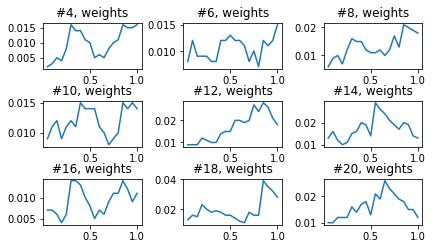

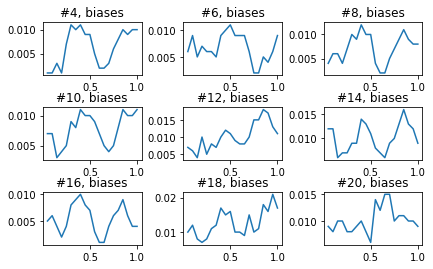

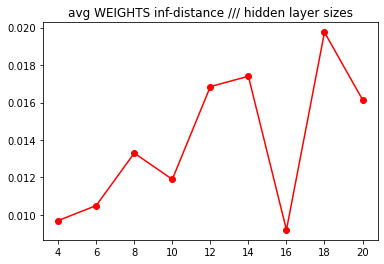

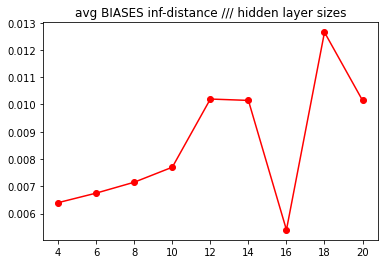

In [10]:
# inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20]
# training gap is 0.05

train_gap = 0.05
h_hidden_size = np.arange(4, 21, 2)
lr = 0.02
batch_size = 32
max_iter = 10000
avg_w_dists_wrt_sizes, avg_b_dists_wrt_sizes = plot_incremental_training_weight_bias_changes(train_gap, h_hidden_size,
                                                                                             lr, batch_size, max_iter,
                                                                                             X1, y1, X2, y2,
                                                                                             False)


inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.02, 
WEIGHTS or BIASES inf-distance /// % of D2 used


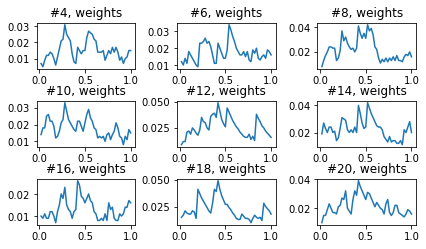

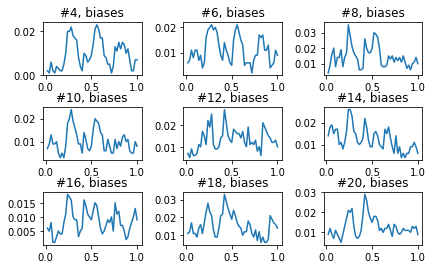

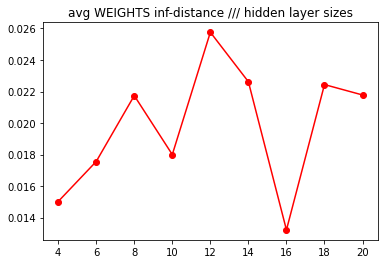

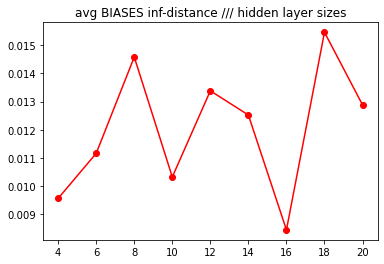

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.05, 
WEIGHTS or BIASES inf-distance /// % of D2 used


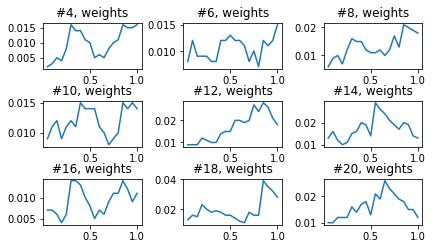

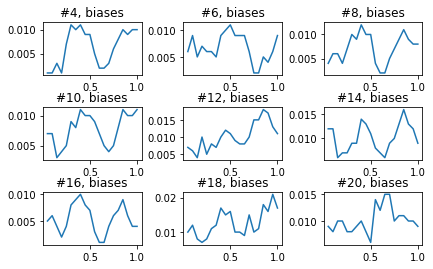

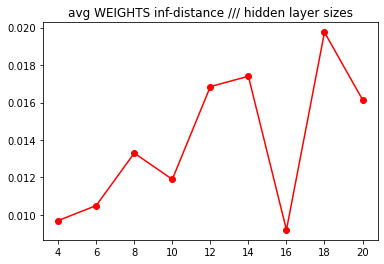

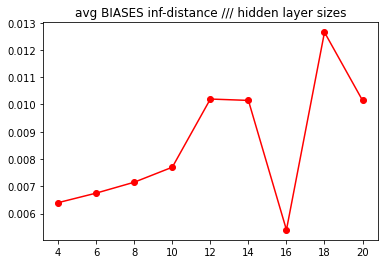

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.1, 
WEIGHTS or BIASES inf-distance /// % of D2 used


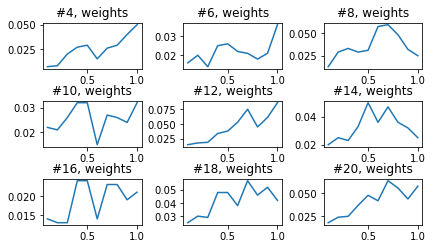

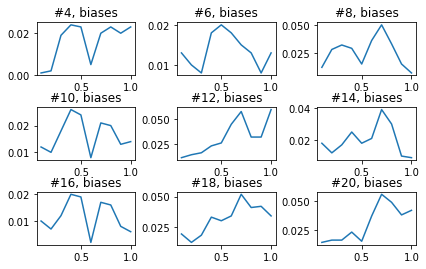

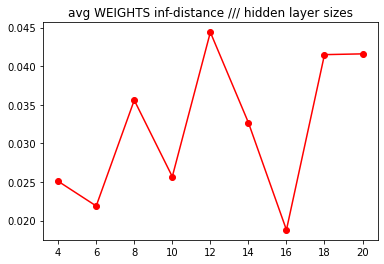

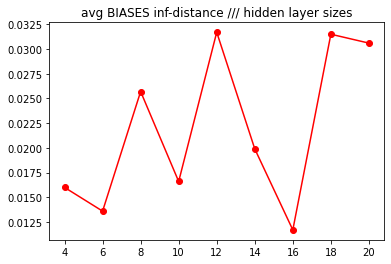

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.2, 
WEIGHTS or BIASES inf-distance /// % of D2 used


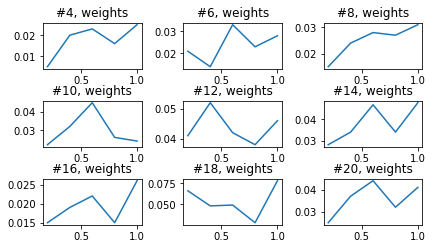

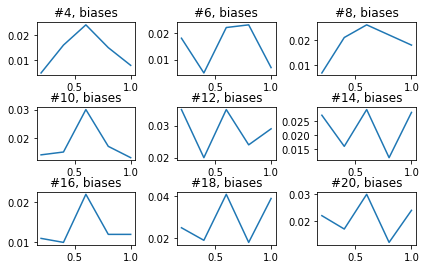

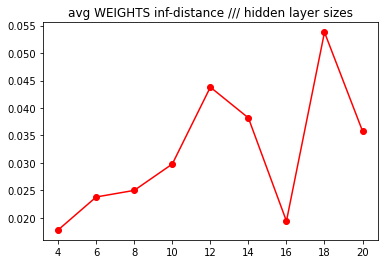

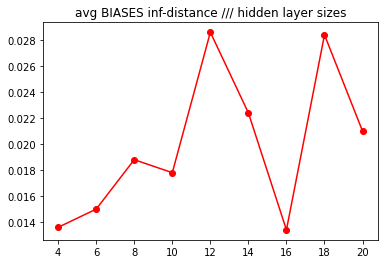

inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20], training gap is 0.25, 
WEIGHTS or BIASES inf-distance /// % of D2 used


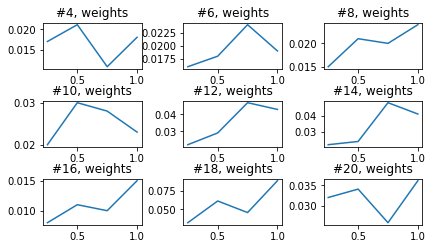

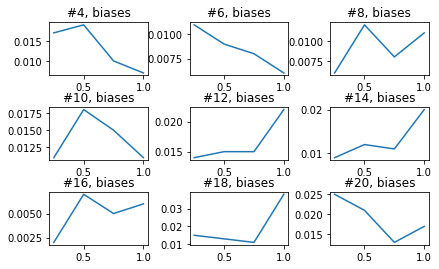

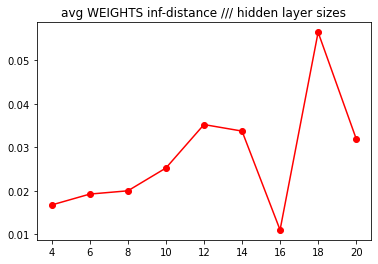

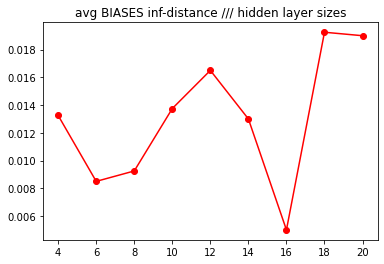

In [11]:
# inf-distance for weights and biases of classifiers with hidden size [ 4  6  8 10 12 14 16 18 20]
# training gap is [0.02, 0.05, 0.10, 0.20]

train_gaps = [0.02, 0.05, 0.10, 0.20, 0.25]
h_hidden_size = np.arange(4, 21, 2)
lr = 0.02
batch_size = 32
max_iter = 10000

avg_w_dists_wrt_gaps = []
avg_b_dists_wrt_gaps = []
for gap in train_gaps:
    thisw, thisb = plot_incremental_training_weight_bias_changes(gap, h_hidden_size,
                                                                 lr, batch_size, max_iter,
                                                                 X1, y1, X2, y2)
    avg_w_dists_wrt_gaps.append(thisw)
    avg_b_dists_wrt_gaps.append(thisb)


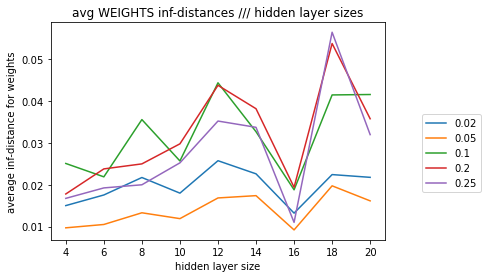

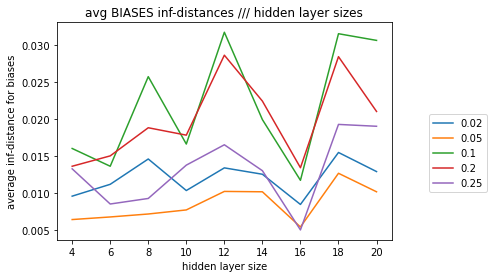

In [12]:
plt.figure(5)
plt.xlabel("hidden layer size")
plt.ylabel("average inf-distance for weights")
for i, item in enumerate(avg_w_dists_wrt_gaps):
    plt.plot(h_hidden_size, item, label=f"{train_gaps[i]}")
plt.legend(bbox_to_anchor=(1.3, 0.6))
plt.title('avg WEIGHTS inf-distances /// hidden layer sizes')

plt.figure(6)
plt.xlabel("hidden layer size")
plt.ylabel("average inf-distance for biases")
for i, item in enumerate(avg_b_dists_wrt_gaps):
    plt.plot(h_hidden_size, item, label=f"{train_gaps[i]}")
plt.legend(bbox_to_anchor=(1.3, 0.6))
plt.title('avg BIASES inf-distances /// hidden layer sizes')
plt.show()


# Experiments: computing counterfactuals

#### Procedures

These procedures are covered by UtilExp class

1. Train M on D1
2. Get delta-min, build M+ and M-: incrementally train M 5 times, using different 10% of D2 each time, then get the maximum inf-distance between the incremented models and M. Construct M+ and M- using delta-min
3. Get M2: incrementally train M on D2
4. Select test instances: randomly select 50 D1 instances to explain, clf(x)=0, desired class=1
5. Report metrics using each baseline

#### Metrics
- Proximity: normalised L1: "Scaling Guarantees for Nearest CEs" page 7
- Sparsity: L0
- Validity-delta: percentage of test instances that 1) have counterfactuals valid on m1, 2) counterfactuals valid on M+ and M- under delta_min
- Validity-m2: percentage of test instances that 1) have counterfactual(s), 2) these counterfactual(s) are all valid on both m1 and m2
- LOF: average LOF score

In [4]:
from joblib import dump, load

clf = load("diabetes.joblib")

gurobipy.setParam("FeasibilityTol", 1e-09)
gurobipy.setParam("OptimalityTol", 1e-09)
gurobipy.setParam("IntFeasTol", 1e-05)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


In [5]:
util_exp = UtilExp(clf, X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map)
print(util_exp.delta_max)
print(util_exp.delta_min)

0.060912822846014514
0.02483980300590756


In [8]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust()
util_exp.evaluate_ces(ours_robust_ces)

50it [00:03, 12.73it/s]


total computation time in s: 3.929999828338623
found: 1.0
average normalised L1: 0.04231543212119834
average normalised L0: 0.19
average lof score: 0.88
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 0.94


In [6]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust()
util_exp.evaluate_ces(ours_non_robust_ces)

50it [00:00, 147.49it/s]


total computation time in s: 0.3419990539550781
found: 1.0
average normalised L1: 0.0278188789594001
average normalised L0: 0.1525
average lof score: 0.96
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.0


In [7]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(1,))
util_exp.evaluate_ces(roar_ces)

50it [00:04, 11.45it/s]
50it [00:02, 21.25it/s]
50it [00:04, 12.10it/s]


total computation time in s: 4.132033348083496
found: 1.0
average normalised L1: 0.04761724986615913
average normalised L0: 0.8333333333333334
average lof score: 0.9259259259259259
counterfactual validity: 0.54
delta validity: 0.06
m2 validity: 0.08


In [6]:
# ROAR-robustness-boosted
roar_ces = util_exp.run_ROAR(labels=(1,), robust=True)
util_exp.evaluate_ces(roar_ces)

50it [00:04, 12.22it/s]
50it [00:02, 21.95it/s]
50it [00:35,  1.40it/s]


total computation time in s: 35.77482461929321
found: 1.0
average normalised L1: 0.06672539704555537
average normalised L0: 0.8636363636363636
average lof score: 0.9545454545454546
counterfactual validity: 0.88
delta validity: 0.66
m2 validity: 0.7


In [15]:
# PROTOTYPES
proto_ces = util_exp.run_proto()
util_exp.evaluate_ces(proto_ces)

No encoder specified. Using k-d trees to represent class prototypes.
50it [13:43, 16.47s/it]


total computation time in s: 823.4209971427917
found: 1.0
average normalised L1: 0.04761724986615913
average normalised L0: 0.8333333333333334
average lof score: 0.9259259259259259
counterfactual validity: 0.54
delta validity: 0.06
m2 validity: 0.08


In [16]:
util_exp.evaluate_ces(proto_ces)

found: 1.0
average normalised L1: 0.02987396395426547
average normalised L0: 0.3925
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.0


In [36]:

num_layers = get_clf_num_layers(clf)
delta = 0
nodes = build_inn_nodes(clf, num_layers)
weights, biases = build_inn_weights_biases(clf, num_layers, delta, nodes)
inn_delta_0 = Inn(num_layers, delta, nodes, weights, biases)

delta = 0.03
nodes = build_inn_nodes(clf, num_layers)
weights, biases = build_inn_weights_biases(clf, num_layers, delta, nodes)
inn_delta_non_0 = Inn(num_layers, delta, nodes, weights, biases)

dataset = Dataset(len(columns) - 1, clf.n_features_in_,
                       build_dataset_feature_types(columns, ordinal_features, discrete_features,
                                                   continuous_features), feat_var_map)
x = util_exp.test_instances[0]
y_prime = 1
# start the iteration
eps = 2
# find CE first:
this_solver = OptSolver(dataset, inn_delta_0, y_prime, x, mode=0, eps=eps, M=10000, x_prime=None)
this_cf = this_solver.compute_counterfactual()
this_solver = OptSolver(dataset, inn_delta_non_0, y_prime, x, mode=1, M=10000, x_prime=this_cf)
found, bound = this_solver.compute_inn_bounds()
print(found, bound)

1 0.9316999843288745


In [11]:
CEs = ours_robust_ces
clf = load("diabetes.joblib")
count = 0
values1 = []
for i, x in tqdm(enumerate(CEs)):
    a0 = np.matmul(x, clf.coefs_[0]) + clf.intercepts_[0]
    n0 = np.zeros(a0.shape)
    for i, val in enumerate(a0):
        if val >= 0:
            n0[i] = val
    a1 = (np.matmul(n0, clf.coefs_[1]) + clf.intercepts_[1])[0]
    print(a1)
    if (a1 < 0):
        count += 1
    values1.append(a1)
print(count)


50it [00:00, 24939.37it/s]

1.0100000101601934
1.010000008903494
1.0100000299144767
1.0100000069634725
1.0100000335614887
0.8100000047216669
0.4100000101812029
0.6100000078697454
1.0100000071829272
1.0100000073082733
1.010000006584347
0.41000001031624156
1.010000006678603
1.0100000417221728
1.2100000412108465
1.0100000043660053
1.0100000334757515
1.0100000299144767
1.0100000365161266
0.6100000081748911
1.0100000112576648
1.0100000056703984
1.0100000056703984
1.010000006480866
0.8100000052972625
1.0100000412532693
1.0100000299144767
0.6100000091233009
1.0100000082438314
1.0100000070913975
1.0100000060483925
0.6100000071460203
1.0100000321097953
1.010000038126341
1.0100000041326196
1.0100000365161266
1.0100000085830365
1.0100000017903572
0.41000000855400587
1.0100000088799648
1.010000034416993
1.0100000086736782
1.010000006689123
0.6100000074202259
1.0100000079474973
1.0100000417221728
1.0100000317046558
0.810000006878872
1.0100000082438314
1.010000008994394
0


In [13]:
delta=0.02482
count = 0
values2 = []
clf2 = copy.deepcopy(clf)
for i, item in enumerate(clf2.coefs_):
    item = item - delta
    clf2.coefs_[i] = item
for i, item in enumerate(clf2.intercepts_):
    item = item - delta
    clf2.intercepts_[i] = item
for i, x in tqdm(enumerate(CEs)):
    a0 = np.matmul(x, clf2.coefs_[0]) + clf2.intercepts_[0]
    n0 = np.zeros(a0.shape)
    for i, val in enumerate(a0):
        if val >= 0:
            n0[i] = val
    a1 = (np.matmul(n0, clf2.coefs_[1]) + clf2.intercepts_[1])[0]
    print(a1)
    if (a1 < 0):
        count += 1
    values2.append(a1)
print(count)

50it [00:00, 16686.44it/s]

0.8096481316844532
0.8048908778247509
1.142117087479726
0.8119472080915798
1.1265287046148869
0.6461163742576658
0.026413079582481624
0.42183330698675137
0.8101843728100083
0.7987914518292486
0.8123303506846943
0.039528930500311255
0.8038728616009164
1.1398262207362557
1.3665389333264666
0.810636780097396
1.1337715679493812
1.142117087479726
1.010762811858287
0.4096329713144996
0.7983837252804465
0.8174555447463504
0.8174555447463504
0.8021987378048295
0.6418985321983347
1.1414509793306862
1.142117087479726
0.40520956321670176
0.8153493669899382
0.8150326186352416
0.814629499437555
0.41542982940388884
1.1152401619699788
0.8712070639520627
0.8175775541138756
1.010762811858287
0.801099159808376
0.831073030746276
0.012348572457012597
0.8017799977037016
1.0634949418880608
0.8150985437466128
0.8229928999336259
0.4059736624617093
0.8144801368992965
1.1398262207362557
1.1455393683412
0.6011097409531806
0.8153493669899382
0.809317865013499
0


In [14]:
count = 0
values2 = []
clf2 = copy.deepcopy(clf)
for i, item in enumerate(clf2.coefs_):
    item = item + delta
    clf2.coefs_[i] = item
for i, item in enumerate(clf2.intercepts_):
    item = item + delta
    clf2.intercepts_[i] = item
for i, x in tqdm(enumerate(CEs)):
    a0 = np.matmul(x, clf2.coefs_[0]) + clf2.intercepts_[0]
    n0 = np.zeros(a0.shape)
    for i, val in enumerate(a0):
        if val >= 0:
            n0[i] = val
    a1 = (np.matmul(n0, clf2.coefs_[1]) + clf2.intercepts_[1])[0]
    print(a1)
    if (a1 < 0):
        count += 1
    values2.append(a1)
print(count)

50it [00:00, 12518.07it/s]

0.9127680227407581
0.9045804593980927
0.8948617037162624
0.9050338759505862
0.9097047752985864
0.6813589200728126
0.8036618690603793
0.8122447588097116
0.8946209948775853
0.8880188344596173
0.8982773055961549
0.7901672890103121
0.8998456757374319
0.8979047245610329
1.0743541888395876
0.8647386643912961
0.9027203525979902
0.8948617037162624
0.8906383392971503
0.8243966179004422
0.9110557200894503
0.8840472207435234
0.8840472207435234
0.8886796452250315
0.7351702947516491
0.8965958246265263
0.8948617037162624
0.8290508003969751
0.9136236734420563
0.9106162589763406
0.9102316693128344
0.8190624073601614
0.9218268759801992
0.8876993757393342
0.8965157140789161
0.8906383392971503
0.9059812135628761
0.8677300238594211
0.8181499676856024
0.9009021634304039
0.8733605633479299
0.912636949305231
0.8870817541171326
0.8282235765850549
0.9022451659994136
0.8979047245610329
0.891355696817869
1.0348355155483282
0.9136236734420563
0.9159935012707284
0
